In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

#model
from catboost import CatBoostClassifier , Pool

from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_recall_curve

### 파일로드

In [2]:
df_train = pd.read_csv('./data/train.csv',index_col = 0)
df_test = pd.read_csv('./data/test.csv',index_col = 0)

In [3]:
train_target = df_train['bin_count']
test_target = df_test['bin_count']
del df_train['bin_count']
del df_test['bin_count']

### train test split

In [4]:
x_train, x_valid , y_train, y_valid = train_test_split(df_train, train_target, test_size =0.25 , stratify = train_target)

### grid search

In [149]:
clf = CatBoostClassifier()
params = {'iterations': [500,1000],
          'learning_rate' :[0.01, 0.1,1],
          'depth': [4, 5, 6]
         }
clf_grid = GridSearchCV(estimator=clf, param_grid=params, scoring='accuracy', cv=4 , n_jobs = -1)

In [ ]:
clf_grid.fit(x_train, y_train)
best_param = clf_grid.best_params_
best_param

In [151]:
model = clf_grid.best_estimator_

In [153]:
#grid search 결과 확인
scores_df = pd.DataFrame(clf_grid.cv_results_)
scores_df[['params','mean_test_score','rank_test_score']]

,params,mean_test_score,rank_test_score
0,"{'depth': 4, 'iterations': 500, 'learning_rate...",0.851150,12
1,"{'depth': 4, 'iterations': 500, 'learning_rate...",0.863673,6
2,"{'depth': 4, 'iterations': 500, 'learning_rate...",0.849566,13
3,"{'depth': 4, 'iterations': 1000, 'learning_rat...",0.856635,9
4,"{'depth': 4, 'iterations': 1000, 'learning_rat...",0.864715,5
5,"{'depth': 4, 'iterations': 1000, 'learning_rat...",0.844377,15
6,"{'depth': 5, 'iterations': 500, 'learning_rate...",0.854449,11
7,"{'depth': 5, 'iterations': 500, 'learning_rate...",0.865267,4
8,"{'depth': 5, 'iterations': 500, 'learning_rate...",0.845297,14
9,"{'depth': 5, 'iterations': 1000, 'learning_rat...",0.858862,8


In [172]:
#예측하기
train_proba = model.predict_proba(x_train)

valid_pred = model.predict(x_valid)
valid_proba = model.predict_proba(x_valid)

test_pred = model.predict(df_test.values)
test_proba = model.predict_proba(df_test.values)

### 결과확인 함수

In [161]:
def get_clf_eval(y_test, pred=None, pred_proba = None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC: {4:.4f}'
          .format(accuracy, precision, recall, f1, roc_auc))

In [162]:
def roc_curve_plot(y_test, pred_proba):
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba)
    plt.plot(fprs, tprs, label='ROC')
    plt.plot([0,1], [0,1], 'k--', label='Random')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.xlim(0, 1); plt.ylim(0, 1)
    plt.xlabel('FPR(1 - Sensitivity)'); plt.ylabel('TPR( Recall )')
    plt.legend()

In [163]:
def precision_recall_curve_plot(y_test, pred_proba):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba)
    
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label = 'precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    start,end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
    

### 예측결과 확인

# training model
training accuracy: 0.9011
[[61275  4020]
 [ 5658 26944]]
# validation model
validation accuracy: 0.8688
[[19926  1840]
 [ 2443  8424]]
# test model
test accuracy: 0.8737
[[66105  6146]
 [ 6711 22816]]
 #train VS val
오차 행렬
[[19926  1840]
 [ 2443  8424]]
정확도: 0.8688, 정밀도: 0.8207, 재현율: 0.7752, F1: 0.7973, AUC: 0.9393
# train VS test
오차 행렬
[[66105  6146]
 [ 6711 22816]]
정확도: 0.8737, 정밀도: 0.7878, 재현율: 0.7727, F1: 0.7802, AUC: 0.9380


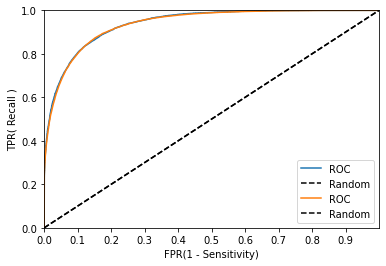

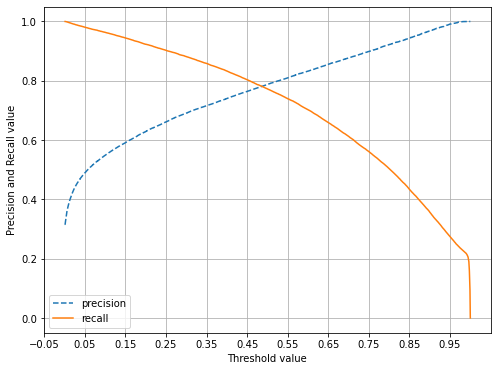

In [177]:

#train 모델 정확도
print('# training model')
print('training accuracy: {0:.4f}'.format(accuracy_score(y_train, train_pred)))
print(confusion_matrix(y_train, train_pred))

#validation 모델 정확도
print('# validation model')
print('validation accuracy: {0:.4f}'.format(accuracy_score(y_valid, valid_pred)))
print(confusion_matrix(y_valid, valid_pred))

#test 모델 정확도
print('# test model')
print('test accuracy: {0:.4f}'.format(accuracy_score(test_target.values,test_pred)))
print(confusion_matrix(test_target.values, test_pred))


#validation set 평가
print('=========================================================================')
print(' #train VS val')
get_clf_eval(y_valid, valid_pred, valid_proba[:,1])
roc_curve_plot(y_valid, valid_proba[:,1])

#test set 평가
print('=========================================================================')
print('# train VS test')
get_clf_eval(test_target.values, test_pred,test_proba[:,1])
roc_curve_plot(test_target.values, test_proba[:, 1])

precision_recall_curve_plot(test_target.values, test_proba[:, 1])

# 아무것도 안주고 그냥 모델을 돌리면?

In [183]:
default_model = CatBoostClassifier(eval_metric='Accuracy')

In [ ]:
default_model.fit(x_train , y_train, eval_set=eval_dataset)

In [185]:
train_pred = default_model.predict(x_train)
valid_pred = default_model.predict(x_valid)
test_pred = default_model.predict(df_test.values)

In [186]:
train_prob = default_model.predict_proba(x_train)
valid_prob = default_model.predict_proba(x_valid)
test_prob = default_model.predict_proba(df_test.values)

# training model
training accuracy: 0.9000
[[61212  4083]
 [ 5709 26893]]
# validation model
validation accuracy: 0.8705
[[19977  1789]
 [ 2437  8430]]
# test model
test accuracy: 0.8743
[[65951  6300]
 [ 6497 23030]]
 #train VS val
오차 행렬
[[19977  1789]
 [ 2437  8430]]
정확도: 0.8705, 정밀도: 0.8249, 재현율: 0.7757, F1: 0.7996, AUC: 0.9393
# train VS test
오차 행렬
[[65951  6300]
 [ 6497 23030]]
정확도: 0.8743, 정밀도: 0.7852, 재현율: 0.7800, F1: 0.7826, AUC: 0.9380


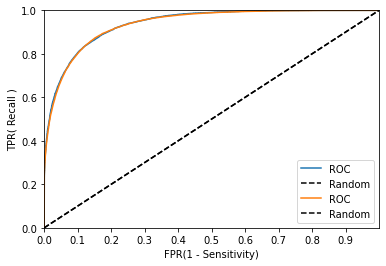

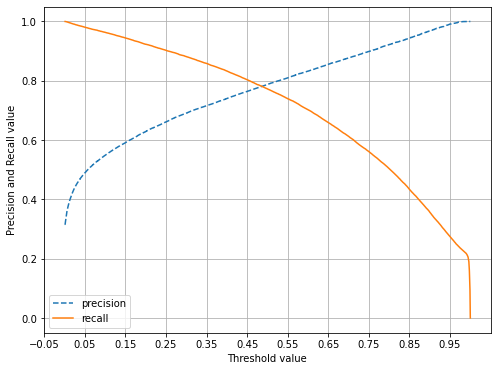

In [187]:
#train 모델 정확도
print('# training model')
print('training accuracy: {0:.4f}'.format(accuracy_score(y_train, train_pred)))
print(confusion_matrix(y_train, train_pred))

#validation 모델 정확도
print('# validation model')
print('validation accuracy: {0:.4f}'.format(accuracy_score(y_valid, valid_pred)))
print(confusion_matrix(y_valid, valid_pred))

#test 모델 정확도
print('# test model')
print('test accuracy: {0:.4f}'.format(accuracy_score(test_target.values,test_pred)))
print(confusion_matrix(test_target.values, test_pred))


#validation set 평가
print('=========================================================================')
print(' #train VS val')
get_clf_eval(y_valid, valid_pred, valid_proba[:,1])
roc_curve_plot(y_valid, valid_proba[:,1])

#test set 평가
print('=========================================================================')
print('# train VS test')
get_clf_eval(test_target.values, test_pred,test_proba[:,1])
roc_curve_plot(test_target.values, test_proba[:, 1])

precision_recall_curve_plot(test_target.values, test_proba[:, 1])


{'depth': 6, 'iterations': 1000, 'learning_rate': 0.1}